## **PROJET : SONG MINING** 🎶

✅ **OBJECTIFS :** Le but de ce projet est d'utiliser les méthodes de NLP pour analyser un album de Musique (The Eminem Show) de l'artiste Eminem afin d'analyser et visualiser les différentes émotions qui y sont exprimées de façon varié.

Le modèle utilisé ici est **TextBlob** pour sa simplicité de mise en oeuvre. 

## **Chargement et Configuration des données**

In [2]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

# --- 1. CONFIGURATION ---
# Téléchargement des stopwords si ce n'est pas déjà fait
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Ajout de stopwords spécifiques aux paroles (ex: "chorus", "verse")
custom_stopwords = {'chorus', 'verse', 'intro', 'outro', 'eminem', 'shady', 'slim', 'yeah', 'yo', 'like', 'get', 'got'}
stop_words.update(custom_stopwords)

# --- 2. CHARGEMENT ET FILTRAGE ---
df = pd.read_csv("Eminem.csv")

# On ne garde que l'album cible
target_album = 'The Eminem Show'
df = df[df['Album'] == target_album].copy()

print(f"✅ Données chargées. {len(df)} chansons conservées pour '{target_album}'.")

# --- 3. FONCTION DE NETTOYAGE ---
def clean_lyrics(text):
    if not isinstance(text, str):
        return ""
    
    # a. Minuscules
    text = text.lower()
    
    # b. Retirer ce qui est entre crochets [] ou parenthèses () souvent indicatifs (ex: [Chorus])
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'\(.*?\)', '', text)
    
    # c. Retirer la ponctuation et les caractères spéciaux
    text = re.sub(r'[^\w\s]', '', text)
    
    # d. Tokenization et retrait des stopwords
    words = text.split()
    clean_words = [w for w in words if w not in stop_words and len(w) > 2]
    
    return " ".join(clean_words)

# --- 4. APPLICATION ---
print("🧹 Nettoyage des paroles en cours...")
df['clean_lyrics'] = df['Lyric'].apply(clean_lyrics)

# On retire les chansons qui seraient devenues vides après nettoyage (instrumentales ?)
df = df[df['clean_lyrics'] != ""]

print("✅ Nettoyage terminé !")
display(df[['Title', 'clean_lyrics']].head())

✅ Données chargées. 15 chansons conservées pour 'The Eminem Show'.
🧹 Nettoyage des paroles en cours...
✅ Nettoyage terminé !


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Title,clean_lyrics
12,Without Me,obie trice obie trice real name gimmicks recor...
15,’Till I Collapse,cause sometimes feel tired feel weak left left...
29,Cleanin’ Out My Closet,wheres snare snare headphones ever hated discr...
32,Superman,dina rae mhmmm inhales high baby talk want tel...
39,Sing for the Moment,ideas nightmares white parents whose worst fea...


In [3]:
df.describe()

,Unnamed: 0,Year
count,15.000000,15.0
mean,90.600000,2002.0
std,59.417169,0.0
min,12.000000,2002.0
25%,35.500000,2002.0
50%,85.000000,2002.0
75%,131.500000,2002.0
max,188.000000,2002.0


## **Pré-traitement des données (lyrics)**

In [12]:
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from wordcloud import WordCloud

# Configuration du style visuel
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (4, 4)

# 1. Calcul des sentiments (Polarité & Subjectivité)
def get_sentiment_metrics(text):
    blob = TextBlob(text)
    return pd.Series({
        'Polarity': blob.sentiment.polarity,         # -1 (Très Négatif) à +1 (Très Positif)
        'Subjectivity': blob.sentiment.subjectivity  # 0 (Objectif/Fait) à 1 (Subjectif/Opinion)
    })

df[['Polarity', 'Subjectivity']] = df['clean_lyrics'].apply(get_sentiment_metrics)

# 2. Calcul de la richesse (Nombre de mots par chanson)
df['Word_Count'] = df['clean_lyrics'].apply(lambda x: len(x.split()))

# 3. Segmentation : Création des catégories (Positif / Neutre / Négatif)
# On utilise un seuil (threshold) pour éviter de classer "0.0001" comme positif.
threshold = 0.05

def categorize(polarity):
    if polarity > threshold: return 'Positif'
    elif polarity < -threshold: return 'Négatif'
    else: return 'Neutre'

df['Category'] = df['Polarity'].apply(categorize)

print("✅ Métriques calculées.")
print(f"Répartition : {df['Category'].value_counts().to_dict()}")
display(df[['Title', 'Polarity', 'Category', 'Word_Count']].head())

✅ Métriques calculées.
Répartition : {'Négatif': 9, 'Neutre': 5, 'Positif': 1}


,Title,Polarity,Category,Word_Count
12,Without Me,-0.082370,Négatif,399
15,’Till I Collapse,-0.058310,Négatif,462
29,Cleanin’ Out My Closet,-0.244233,Négatif,349
32,Superman,-0.008813,Neutre,587
39,Sing for the Moment,-0.059409,Négatif,407


## **Visualisation globale des données**

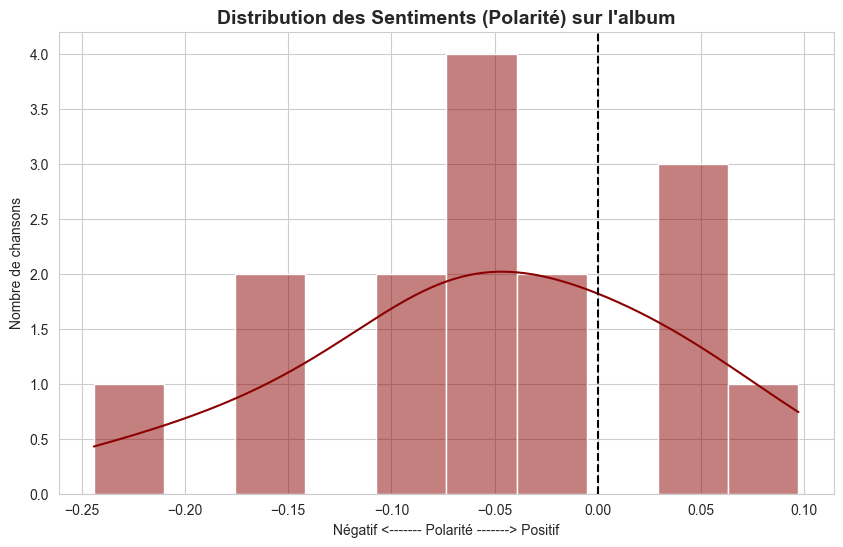

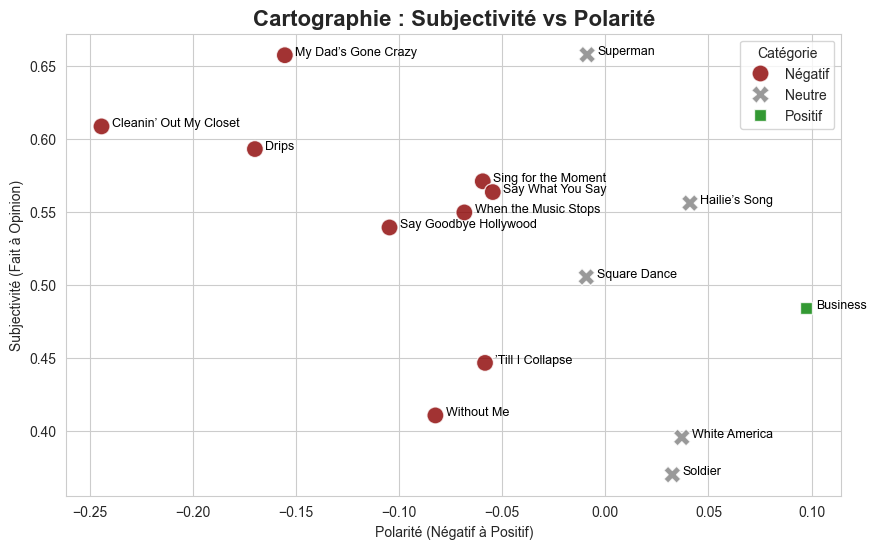

In [18]:
# --- GRAPHIQUE 1 : Distribution de la Polarité (Histogramme) ---
plt.figure(figsize=(10,6))
sns.histplot(df['Polarity'], bins=10, kde=True, color='#8B0000') # Rouge sombre pour Eminem
plt.title('Distribution des Sentiments (Polarité) sur l\'album', fontsize=14, fontweight='bold')
plt.xlabel('Négatif <------- Polarité -------> Positif')
plt.ylabel('Nombre de chansons')
plt.axvline(0, color='black', linestyle='--') # Ligne centrale
plt.show()

# --- GRAPHIQUE 2 : Carte des Sentiments (Scatter Plot) ---
plt.figure(figsize=(10,6))
# On utilise hue='Category' pour colorer selon le sentiment
scatter = sns.scatterplot(data=df, x='Polarity', y='Subjectivity', 
                          hue='Category', style='Category', 
                          palette={'Positif': 'green', 'Négatif': '#8B0000', 'Neutre': 'grey'}, 
                          s=150, alpha=0.8)

# Ajouter les titres des chansons sur les points pour l'identification
for i in range(df.shape[0]):
    plt.text(df.Polarity.iloc[i]+0.005, df.Subjectivity.iloc[i], 
             df.Title.iloc[i], fontsize=9, color='black')

plt.title('Cartographie : Subjectivité vs Polarité', fontsize=16, fontweight='bold')
plt.xlabel('Polarité (Négatif à Positif)')
plt.ylabel('Subjectivité (Fait à Opinion)')
plt.legend(title='Catégorie', loc='upper right')
plt.show()

## **Analyse par polarité (Positive vs Négative)**

Analyse des lyrics par polarité. 
WordCloud comparatif entre les différents émotions ressenties.

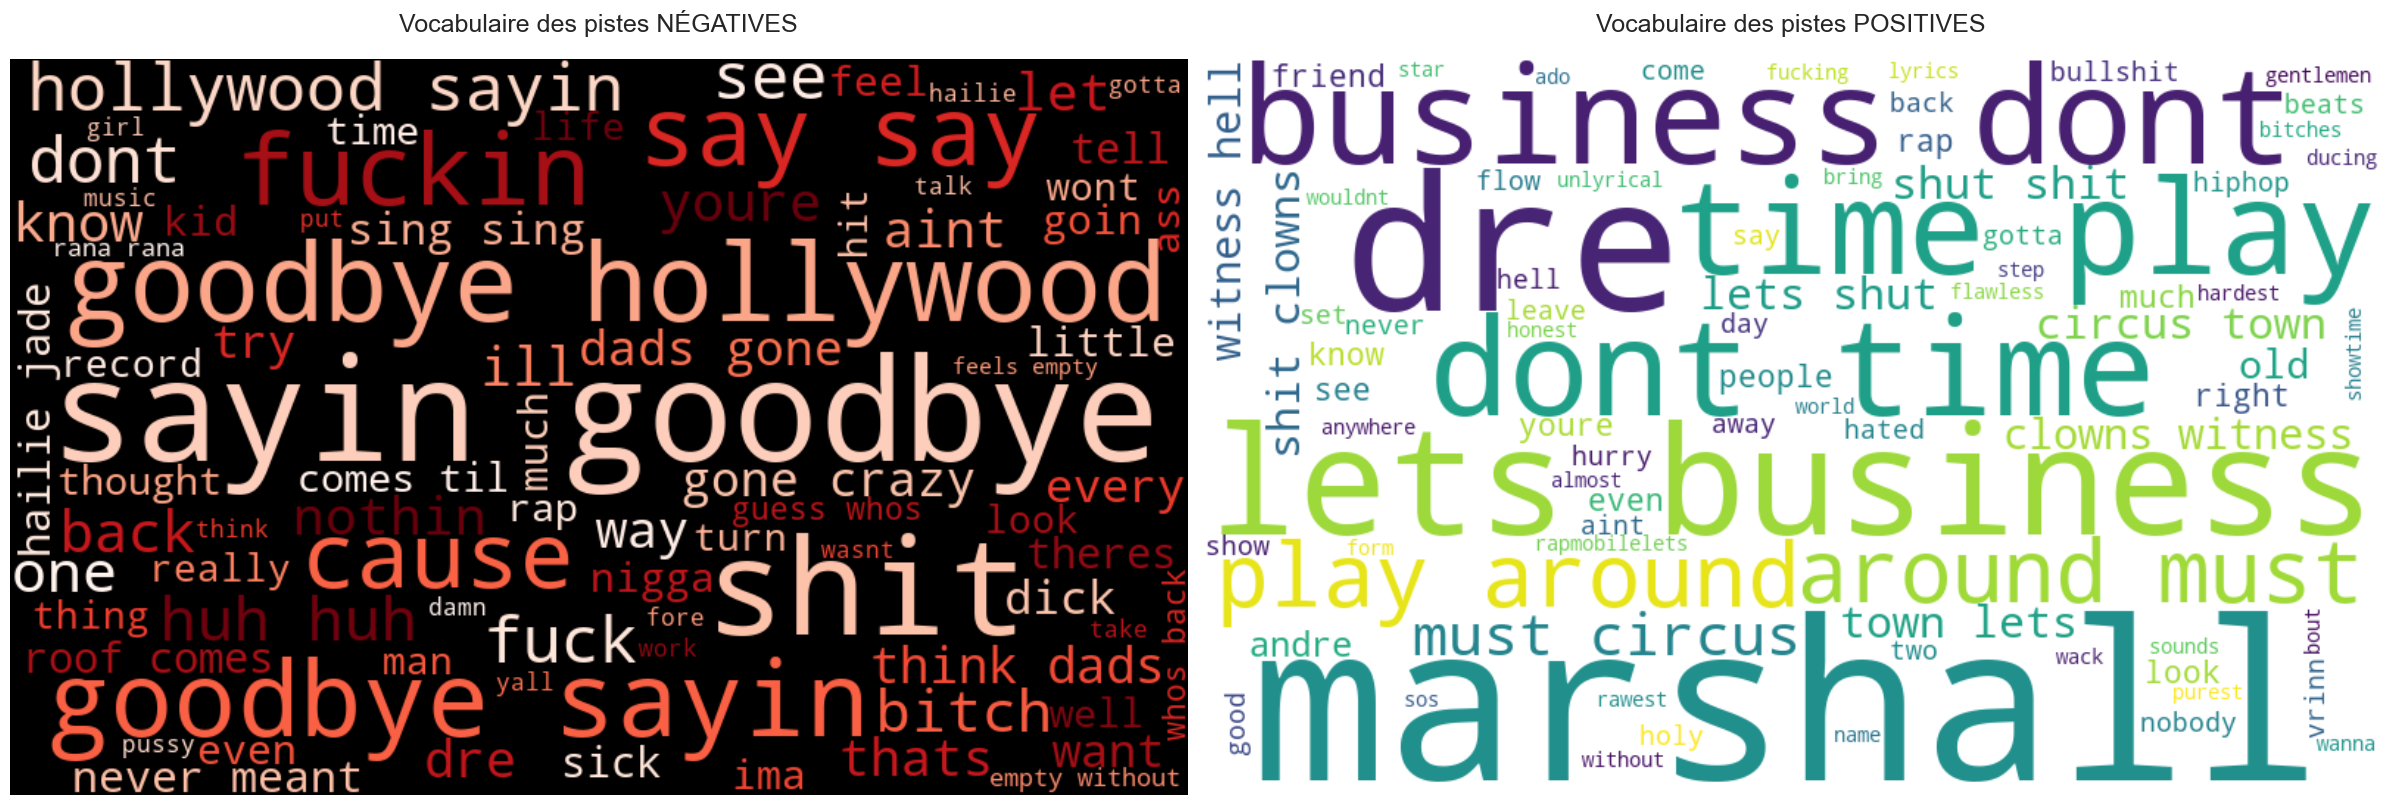

In [19]:
# Préparation des textes par catégorie
neg_text = ' '.join(df[df['Category'] == 'Négatif']['clean_lyrics'])
pos_text = ' '.join(df[df['Category'] == 'Positif']['clean_lyrics'])

# --- GRAPHIQUE 3 & 4 : Wordclouds Comparatifs ---
fig, axes = plt.subplots(1, 2, figsize=(24, 10)) # Création d'une grille 1 ligne, 2 colonnes

# 1. Wordcloud Négatif (Thème Sombre/Rouge)
if len(neg_text) > 0:
    wc_neg = WordCloud(background_color='black', colormap='Reds', 
                       width=800, height=500, max_words=80).generate(neg_text)
    axes[0].imshow(wc_neg, interpolation='bilinear')
    axes[0].set_title("Vocabulaire des pistes NÉGATIVES", fontsize=18, pad=20)
    axes[0].axis('off')
else:
    axes[0].text(0.5, 0.5, "Pas de données négatives", ha='center')

# 2. Wordcloud Positif (Thème Clair/Vert ou Bleu)
if len(pos_text) > 0:
    # On utilise 'viridis' ou 'ocean' pour contraster avec le rouge
    wc_pos = WordCloud(background_color='white', colormap='viridis', 
                       width=800, height=500, max_words=80).generate(pos_text)
    axes[1].imshow(wc_pos, interpolation='bilinear')
    axes[1].set_title("Vocabulaire des pistes POSITIVES", fontsize=18, pad=20)
    axes[1].axis('off')
else:
    axes[1].text(0.5, 0.5, "Pas de données positives", ha='center')

plt.tight_layout()
plt.show()

## **Analyse Structurelle (Complexité)**

Enfin, nous analysons si l'humeur de la chanson influence sa longueur. Est-ce qu'Eminem écrit plus de texte quand il est en colère (négatif) ou quand il est plus léger ?

C:\Users\hp\AppData\Local\Temp\ipykernel_24220\3045465908.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Category', y='Word_Count',


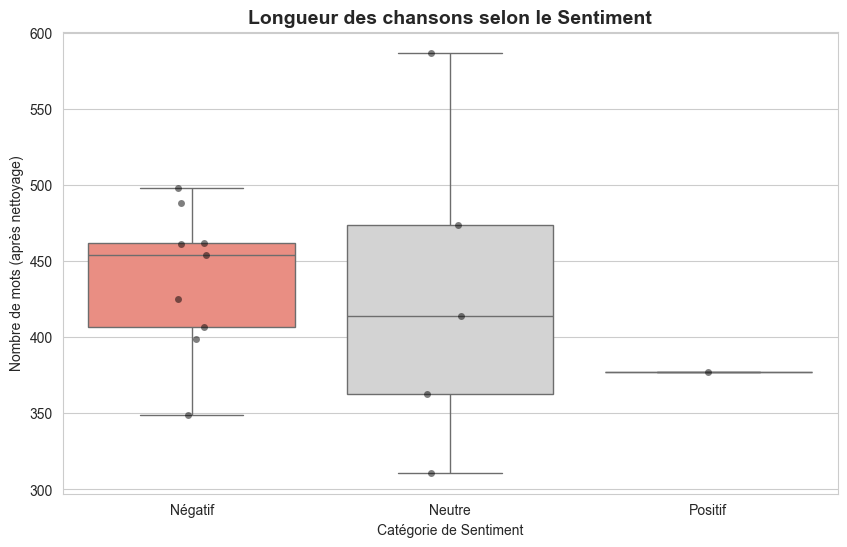

C:\Users\hp\AppData\Local\Temp\ipykernel_24220\3045465908.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mot', y='Fréquence', data=word_freq, palette='magma')


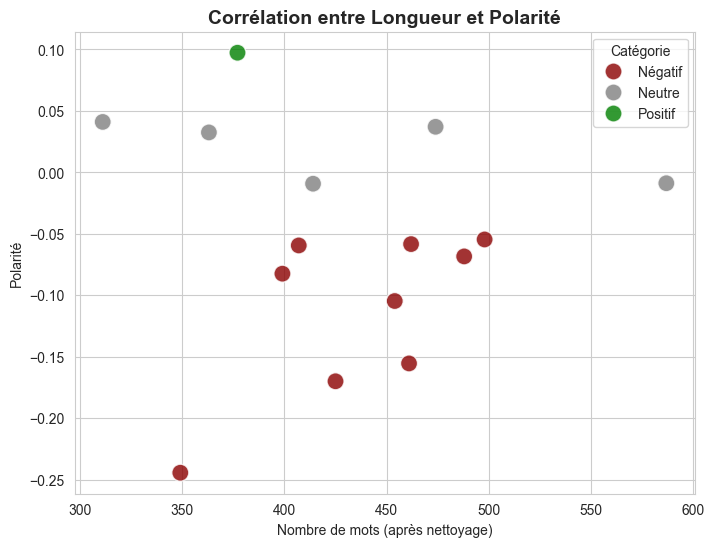

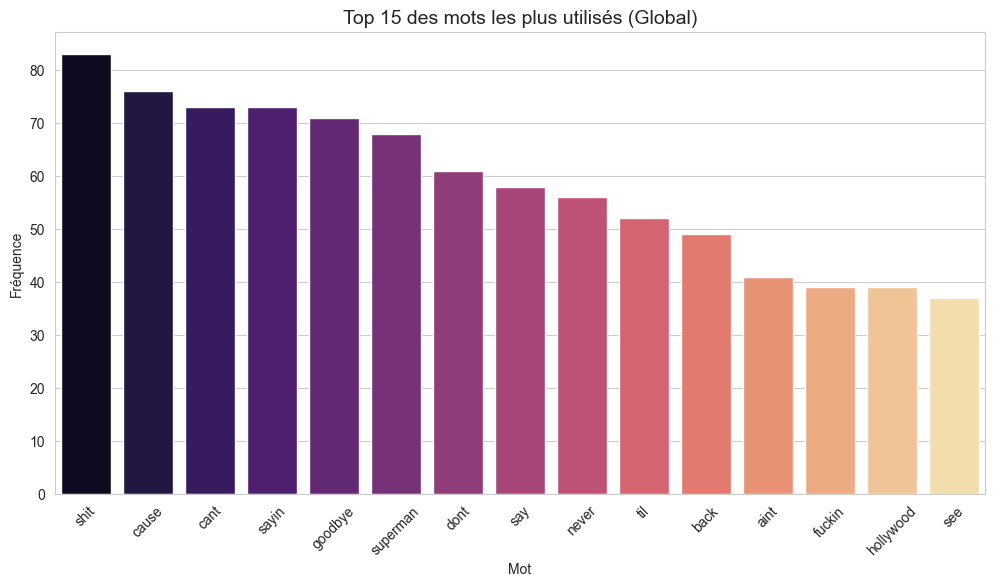

In [20]:
# --- GRAPHIQUE 5 : Complexité Textuelle (Boxplot) ---
plt.figure(figsize=(10, 6))

# Le boxplot permet de voir la médiane et les écarts
sns.boxplot(data=df, x='Category', y='Word_Count', 
            order=['Négatif', 'Neutre', 'Positif'],
            palette={'Positif': 'lightgreen', 'Négatif': 'salmon', 'Neutre': 'lightgrey'})

# On ajoute les points réels par dessus pour voir la distribution exacte (Swarmplot)
sns.stripplot(data=df, x='Category', y='Word_Count', 
              order=['Négatif', 'Neutre', 'Positif'],
              color='black', alpha=0.5, jitter=True)

plt.title('Longueur des chansons selon le Sentiment', fontsize=14, fontweight='bold')
plt.ylabel('Nombre de mots (après nettoyage)')
plt.xlabel('Catégorie de Sentiment')
plt.show()

#Matrice de corrélation entre longueur et polarité
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Word_Count', y='Polarity', 
                hue='Category', palette={'Positif': 'green', 'Négatif': '#8B0000', 'Neutre': 'grey'}, 
                s=150, alpha=0.8)
plt.title('Corrélation entre Longueur et Polarité', fontsize=14, fontweight='bold')
plt.xlabel('Nombre de mots (après nettoyage)')
plt.ylabel('Polarité')
plt.legend(title='Catégorie', loc='upper right')

# --- GRAPHIQUE 6 (Bonus) : Top 15 Mots Uniques Fréquents (Global) ---
# Pour finir sur une stat pure
all_words = ' '.join(df['clean_lyrics']).split()
word_freq = pd.DataFrame(Counter(all_words).most_common(15), columns=['Mot', 'Fréquence'])

plt.figure(figsize=(12, 6))
sns.barplot(x='Mot', y='Fréquence', data=word_freq, palette='magma')
plt.title('Top 15 des mots les plus utilisés (Global)', fontsize=14)
plt.xticks(rotation=45)
plt.show()